In [1]:
import sys
sys.path.append("..")
import Data as dt
import ChevalParesseux_lib as lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Sets the number of jobs to use for parallel processing
n_jobs = 5

In [2]:
# I. Load data
spy = dt.load_data(ticker='SPY')
spy['code'] = 'SPY'

vix = dt.load_data(ticker='VIX')
vix['code'] = 'VIX'

rates = dt.load_data(ticker='US_rates')
rates['code'] = 'US_rates'

We don't actually data on the traded options, however we dispose of the necessary to generate synthetic options data (underlying price, implied volatility and risk-free rates). As the VIX is averaging through a bunch of different kind of options for 30 days, we will stay in those bounds for our synthetic data. 

In [16]:
# I. Some preprocessing
spy_close = spy[['date', 'close']]
spy_close.index = pd.to_datetime(spy_close['date'])
spy_close = spy_close.drop(columns=['date'])
spy_close.rename(columns={'close': 'spy'}, inplace=True)
spy.sort_index(inplace=True)

vix_close = vix[['date', 'close']]
vix_close.index = pd.to_datetime(vix_close['date'])
vix_close = vix_close.drop(columns=['date'])
vix_close.rename(columns={'close': 'vix'}, inplace=True)
vix.sort_index(inplace=True)

rates_4w = rates[['date', '4 WEEKS COUPON EQUIVALENT']]
rates_4w.index = pd.to_datetime(rates_4w['date'])
rates_4w = rates_4w.drop(columns=['date'])
rates_4w.rename(columns={'4 WEEKS COUPON EQUIVALENT': 'rf_4w'}, inplace=True)
rates_4w.sort_index(inplace=True)

# II. Merge data
df = pd.concat([spy_close, vix_close, rates_4w], axis=1)
df = df.dropna(axis=0, how='any')

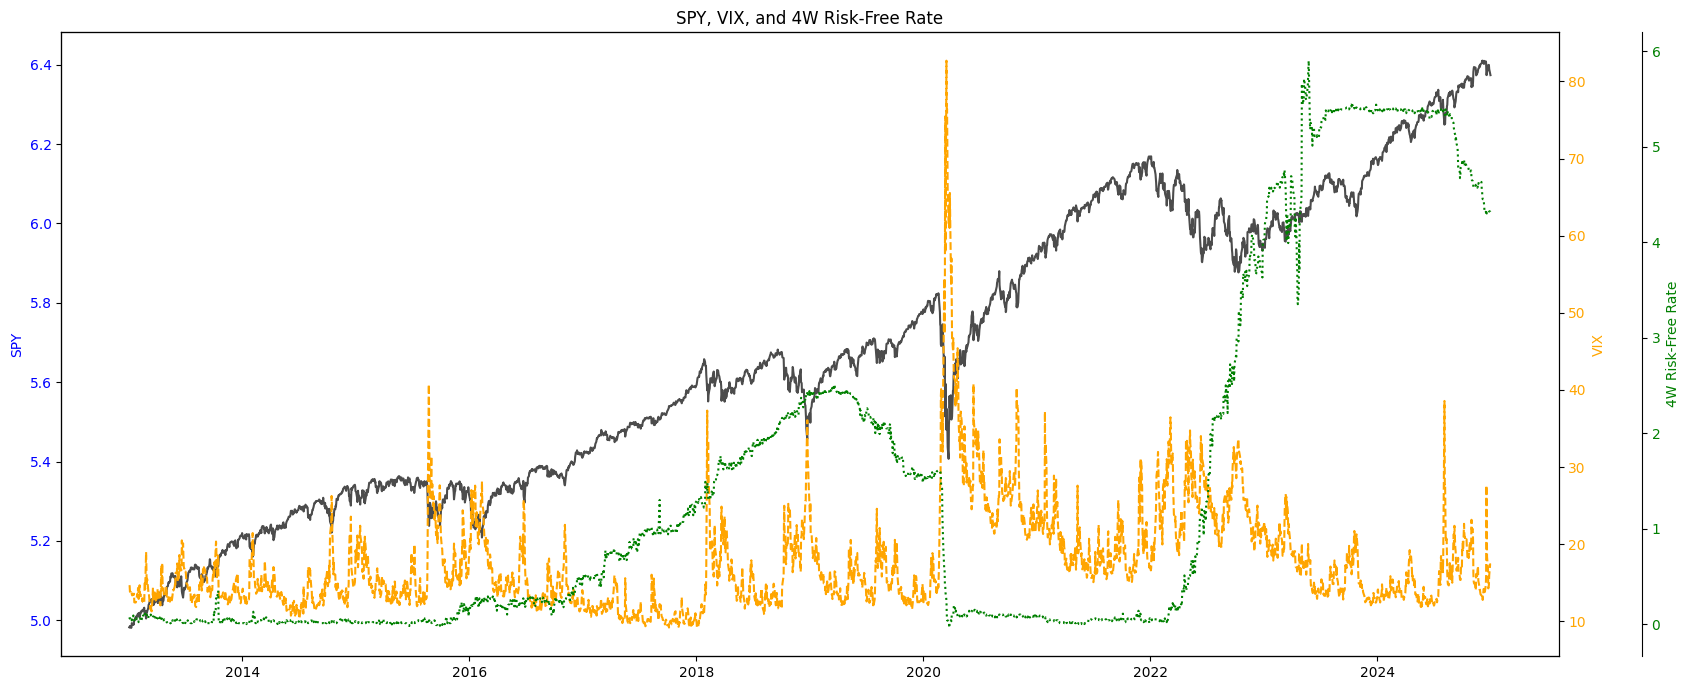

In [24]:
# III. Plotting
fig, ax1 = plt.subplots(figsize=(17, 7))

ax1.plot(df.index, np.log(df['spy']), color='black', label='SPY Close Price', alpha=0.7)
ax1.set_ylabel('SPY', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df.index, df['vix'], color='orange', label='VIX Close Price', linestyle='--')
ax2.set_ylabel('VIX', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(("outward", 60))
ax3.plot(df.index, df['rf_4w'], color='green', label='4W Risk-Free Rate', linestyle=':')
ax3.set_ylabel('4W Risk-Free Rate', color='green')
ax3.tick_params(axis='y', labelcolor='green')

plt.title('SPY, VIX, and 4W Risk-Free Rate')
fig.tight_layout()
plt.show()

Let's create some synthetic data

In [25]:
import scipy.stats as stats

def get_european_BSM(
    spot: float, 
    strike: float, 
    maturity: float, 
    risk_free_rate: float, 
    volatility: float,
) -> tuple:
    """
    Computes the price of a European option using the Black-Scholes-Merton formula.

    Args: 
        spot (float): The current price of the underlying asset.
        strike (float): The strike price of the option.
        maturity (float): Time to maturity (in years).
        risk_free_rate (float): The annual risk-free interest rate.
        volatility (float): The annual volatility of the underlying asset.

    Returns:
        tuple: (call_price, put_price)
            call_price (float): Price of the European call option.
            put_price (float): Price of the European put option.
    """
    # ======= I. Check inputs =======
    if spot <= 0 or strike <= 0 or maturity <= 0 or volatility <= 0:
        raise ValueError("All inputs must be strictly positive.")

    # ======= II. Calculate d1 and d2 =======
    d1 = (np.log(spot / strike) + (risk_free_rate + 0.5 * volatility ** 2) * maturity) / (volatility * np.sqrt(maturity))
    d2 = d1 - volatility * np.sqrt(maturity)

    # ======= III. Calculate N(d1), N(d2), N(-d1), N(-d2) =======
    N_d1 = stats.norm.cdf(d1)
    N_d2 = stats.norm.cdf(d2)
    N_minus_d1 = stats.norm.cdf(-d1)
    N_minus_d2 = stats.norm.cdf(-d2)

    # ======= IV. Calculate call and put prices =======
    call_price = spot * N_d1 - strike * np.exp(-risk_free_rate * maturity) * N_d2
    put_price = strike * np.exp(-risk_free_rate * maturity) * N_minus_d2 - spot * N_minus_d1

    return call_price, put_price
